# Wasserstein GAN in Pytorch

In [26]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

In [27]:
import torch_utils; importlib.reload(torch_utils)
from torch_utils import *

The good news is that in the last month the GAN training problem has been solved! [This paper](https://arxiv.org/abs/1701.07875) shows a minor change to the loss function and constraining the weights allows a GAN to reliably learn following a consistent loss schedule.

First, we, set up batch size, image size, and size of noise vector:

In [28]:
bs,sz,nz = 256,64,100

Load dungeon maps from data/maps

In [29]:
import csvdataset; importlib.reload(csvdataset)
from csvdataset import CSVDataset

mapsLoader = CSVDataset("data/digger", "map", 20000)
dataloader = torch.utils.data.DataLoader(mapsLoader, bs, True, num_workers=4)

n = len(dataloader);
n

79

In [30]:
mapsLoader[0].shape

torch.Size([1, 64, 64])

Our activation function will be `tanh`, so we need to do some processing to view the generated images.

In [31]:
def show(img, fs=(6,6)):
    plt.figure(figsize = fs)
    plt.imshow(np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')

## Create model

The CNN definitions are a little big for a notebook, so we import them.

In [113]:
import dcgan; importlib.reload(dcgan)
from dcgan import DCGAN_D, DCGAN_GU2

Pytorch uses `module.apply()` for picking an initializer.

In [114]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)): 
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [115]:
netG = DCGAN_GU2(sz, nz, 1, 64, 1, 1).cuda()
netG.apply(weights_init);

In [116]:
netD = DCGAN_D(sz, 1, 64, 1, 1).cuda()
netD.apply(weights_init);

Just some shortcuts to create tensors and variables.

In [117]:
from torch import FloatTensor as FT
def Var(*params): return Variable(FT(*params).cuda())

In [118]:
def create_noise(b): 
    return Variable(FT(b, nz, 1, 1).cuda().normal_(0, 1))

In [119]:
# Input placeholder
input = Var(bs, 3, sz, nz)
# Fixed noise used just for visualizing images when done
fixed_noise = create_noise(bs)
# The numbers 0 and -1
one = torch.FloatTensor([1]).cuda()
mone = one * -1

An optimizer needs to be told what variables to optimize. A module automatically keeps track of its variables.

In [120]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

One forward step and one backward step for D

In [121]:
def step_D(v, init_grad):
    err = netD(v)
    err.backward(init_grad)
    return err

In [122]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

In [123]:
lossD = []
lossG = []
lossDreal = []
lossDfake = []

In [124]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in range(niter):
        epoch_filename = str.format('gen_epoch_{}.pt', epoch)
        if not (epoch - 1) % 100:
            torch.save(netG, epoch_filename)
        data_iter = iter(dataloader)
        i = 0
        while i < n:
            make_trainable(netD, True)
            d_iters = (100 if first and (gen_iterations < 25) or gen_iterations % 500 == 0 
                       else 5)

            j = 0
            while j < d_iters and i < n:
                j += 1; i += 1
                for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                real = Variable(next(data_iter).cuda())
                netD.zero_grad()
                errD_real = step_D(real, one)

                fake = netG(create_noise(real.size()[0]))
                input.data.resize_(real.size()).copy_(fake.data)
                errD_fake = step_D(input, mone)
                errD = errD_real - errD_fake
                optimizerD.step()
                #print('i[%d]' % i)

            make_trainable(netD, False)
            netG.zero_grad()
            errG = step_D(netG(create_noise(bs)), one)
            optimizerG.step()
            gen_iterations += 1
            
            print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f' % (
            epoch, niter, gen_iterations, n,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))
            lossD.append(errD.data[0])
            lossG.append(errG.data[0])
            lossDreal.append(errD_real.data[0])
            lossDfake.append(errD_fake.data[0])

    torch.save(netG, epoch_filename)

In [125]:
%time train(2000, True)

torch.Size([256, 1, 64, 64])
torch.Size([256, 1, 64, 64])
torch.Size([256, 1, 64, 64])
torch.Size([256, 1, 64, 64])
torch.Size([256, 1, 64, 64])
torch.Size([256, 1, 64, 64])
torch.Size([256, 1, 64, 64])
torch.Size([256, 1, 64, 64])
torch.Size([256, 1, 64, 64])
torch.Size([256, 1, 64, 64])
torch.Size([256, 1, 64, 64])
torch.Size([256, 1, 64, 64])
torch.Size([256, 1, 64, 64])
torch.Size([256, 1, 64, 64])
torch.Size([256, 1, 64, 64])


Process Process-7735:
Traceback (most recent call last):
Process Process-7734:
Traceback (most recent call last):
  File "/home/flend/anaconda3/envs/pytorch/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process Process-7736:
  File "/home/flend/anaconda3/envs/pytorch/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/flend/anaconda3/envs/pytorch/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/flend/anaconda3/envs/pytorch/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/flend/anaconda3/envs/pytorch/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/flend/anaconda3/envs/pytorch/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  F

torch.Size([256, 1, 64, 64])


  File "/home/flend/anaconda3/envs/pytorch/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


KeyboardInterrupt: 

In [74]:
iter(dataloader).next().size()

torch.Size([256, 1, 64, 64])

In [221]:
# dimension checking
#batch = next(iter(dataloader))
#batch


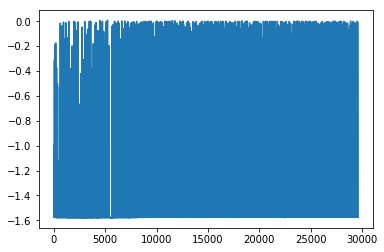

In [21]:
plt.plot(lossD)

## View

In [22]:
fake = netG(fixed_noise).data.cpu()

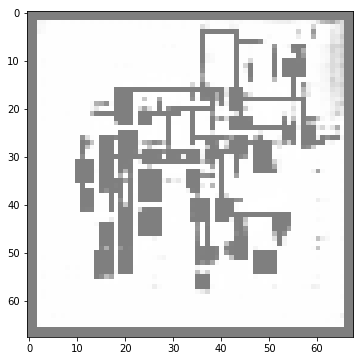

In [25]:
show(vutils.make_grid(fake[5:6,:,:,:]))

In [225]:
fake[44,0,:,:]


 0.0059  0.0013  0.0025  ...   0.0022  0.0039  0.0123
 0.0008  0.0016  0.0299  ...   0.0070  0.0176  0.0018
 0.0007  0.0034  0.0265  ...   0.0136  0.0339  0.0042
          ...             ⋱             ...          
 0.0008  0.0065  0.0428  ...   0.0164  0.0126  0.0014
 0.0008  0.0115  0.0322  ...   0.0173  0.0152  0.0017
 0.0075  0.0015  0.0029  ...   0.0016  0.0025  0.0074
[torch.FloatTensor of size 64x64]

In [139]:
fakeshow(vutils.make_grid(iter(dataloader).next()[0]))

NameError: name 'fakeshow' is not defined

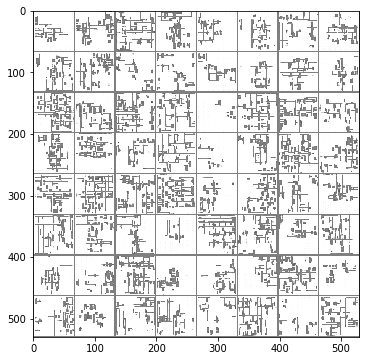

In [186]:
show(vutils.make_grid(fake))

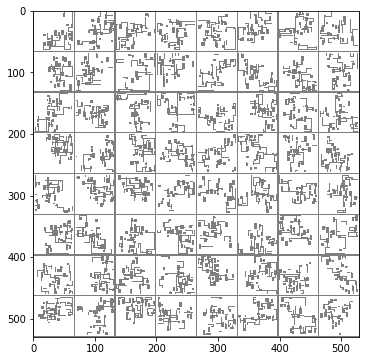

In [180]:
show(vutils.make_grid(iter(dataloader).next()))

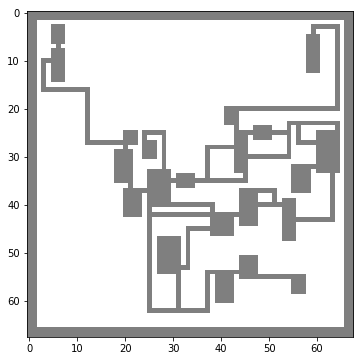

In [24]:
show(vutils.make_grid(iter(dataloader).next()[6:7,:,:,:]))